In [2]:
### LOADING DATA FILE
from google.colab import files
uploaded = files.upload()



Saving weekly_in_situ_co2_mlo (2).csv to weekly_in_situ_co2_mlo (2).csv


In [31]:
### IMPORTING THE MODULES 
import io
import numpy as np
import pandas as pd 
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan
import math
import seaborn
from datetime import datetime

#get dataset 
df = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo (2).csv']))

#convert the dataframe into a numpy array
co2_data = df.to_numpy()

#Convert dates from strings to number of days since start of 1958
frmt = '%Y-%m-%d'
beginning_date = '1958-1-1'
b_date = datetime.strptime(beginning_date, frmt) #strptime converts the string to datetime object

#calculate days since 1st jan of 1958 to get a numerical t range for modeling
for i in range(len(co2_data)):
    curr_date = co2_data[i,0]
    c_date = datetime.strptime(curr_date, frmt)
    diff = c_date - b_date #subtract current date from the beginning
    co2_data[i,0] = diff.days


t_vals = co2_data[:,0] #time in days since 1st jan, 1958
x_vals = co2_data[:,1] #CO2 levels

n = len(co2_data) #number of observations in dataset
 #15000 days till 2060 from 2017 
 #divide 15000 by 7 to get n_future for weekly data collection expectation at Mauna Loa
n_future = 15000

#preview the numpy array with days since 1st jan on 1st col
#and CO2 levels in ppm on second column
print(co2_data) 

[[94 317.31]
 [101 317.69]
 [108 317.58]
 ...
 [23040 415.68]
 [23047 416.91]
 [23054 416.45]]


In [4]:
### STAN MODELING 

stan_code = '''
data {
  int <lower=0> n; //number of observations of CO2 levels 
  int <lower=0> n_future; //number of weekly observations expected until 2060
  vector[n] x; //vectorizd form of CO2 measurements
  vector[n] t; //vectorized form of time in days since 1958
}

parameters {
  //posterior parameters 
  real<lower=0> c1; //scaling component
  real c2; //amplitude parameter
  real<lower=0> c3; // Baseline CO2 levels in 1958
  real<lower=0> c4; // Gradient
  real<lower=0> std; // Noise
}

model {
  //non-informative gaussian priors
  c1 ~ normal(0, 5); 
  c3 ~ normal(300, 3);

  //likelihood function 
  for(i in 1:n){
    x[i]~normal(c1*t[i]^1.5 + c4*t[i] + c2*sin(2*pi()*t[i]/365.25)+c3, std);
  }

}
//for predictions into the future
generated quantities {
  real x_future[n_future];
  for(i in 1:n_future) {
    x_future[i] = normal_rng(c1*(t[n]+i)^1.5 +c4*(t[n]+i)+ c2*sin(2*pi()*(t[n]+i)/365.25)+c3, std);
    }
}
'''

#Compile the model 
stan_model = pystan.StanModel(model_code=stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_277af4efff3d5f87ceaa063fa943ac17 NOW.


In [32]:
stan_data = {
    'n': n, #number of days since 1 jan 1958
    'n_future': n_future, #40 years into the future is approximately 15000
    'x': list(x_vals),
    't': list(t_vals) 
}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
#Preview the parameters
parameters = ['c1','c2','c3','c4','std'] 
print(results.stansummary(pars=parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_277af4efff3d5f87ceaa063fa943ac17.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c1  2.6e-5  4.0e-9 1.5e-7 2.6e-5 2.6e-5 2.6e-5 2.6e-5 2.7e-5   1506    1.0
c2    2.69  7.5e-4   0.03   2.63   2.67   2.69   2.72   2.76   1874    1.0
c3  316.29  1.9e-3   0.08 316.14 316.24 316.29 316.35 316.44   1809    1.0
c4  2.3e-4  6.3e-7 2.4e-5 1.8e-4 2.1e-4 2.3e-4 2.4e-4 2.7e-4   1509    1.0
std   1.29  3.5e-4   0.02   1.26   1.28   1.29    1.3   1.32   2083    1.0

Samples were drawn using NUTS at Sat Apr 24 01:37:57 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


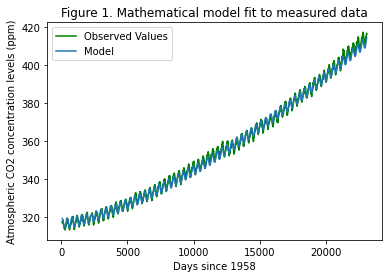

In [33]:
#Parameters estimated by Stan 
c1 = .000026
c2 = 2.69
c3 = 316.3
c4 = .00023

#likelihood function (also used in Stan model)
def f(t,c1,c2,c3,c4):
  values = []
  for i in range(len(t)):
    values.append(c1*t[i]**1.5+c4*t[i]+c2*math.sin(2*math.pi*t[i]/365.25)+c3)
  return values

#Plotting the observed values against stan's calculations for observed values to check the fit. 
func_vals = f(list(t_vals), c1,c2,c3,c4)
plt.plot(list(t_vals), list(x_vals), color = 'green',label='Observed Values')
plt.plot(list(t_vals),func_vals,label='Model')
plt.title('Figure 1. Mathematical model fit to measured data')
plt.xlabel('Days since 1958')
plt.ylabel('Atmospheric CO2 concentration levels (ppm)')
plt.legend()




15000


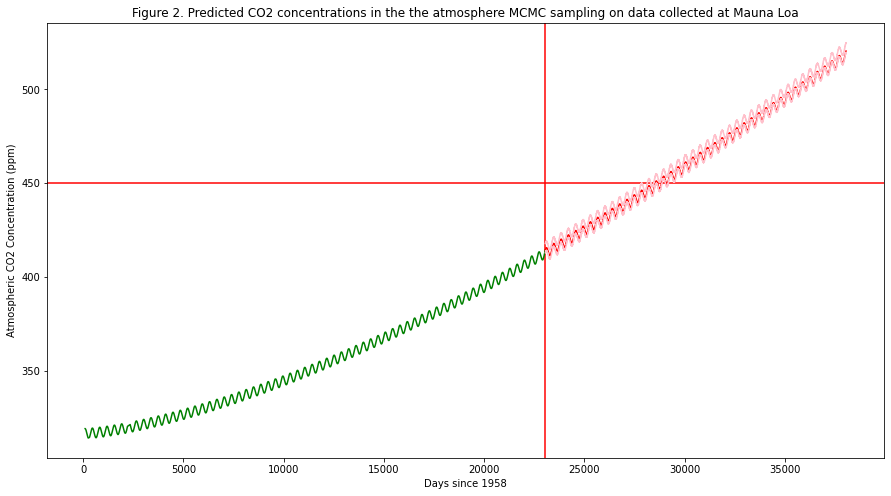

In [39]:
fut_range = np.arange(max(list(t_vals)),max(list(t_vals))+n_future)
predictions = samples['x_future']
prediction_intervals = np.percentile(predictions, axis=0, q=[2.5, 97.5])
plt.figure(figsize=(15, 8))
observed = f(list(t_vals), c1,c2,c3,c4)
unobserved = f(fut_range,c1,c2,c3,c4)
plt.axvline(x= max(t_vals), color = 'red')
plt.axhline(y= 450, color = 'red')
plt.plot(list(t_vals),observed, color = 'green')
plt.plot(fut_range,unobserved, color='red')
plt.plot(fut_range, prediction_intervals[1, :],color='pink')
plt.plot(fut_range, prediction_intervals[0, :],color='pink')
plt.title('Figure 2. Predicted CO2 concentrations in the the atmosphere MCMC sampling on data collected at Mauna Loa')
plt.xlabel('Days since 1958')
plt.ylabel('Atmospheric CO2 Concentration (ppm)')
print(n_future)

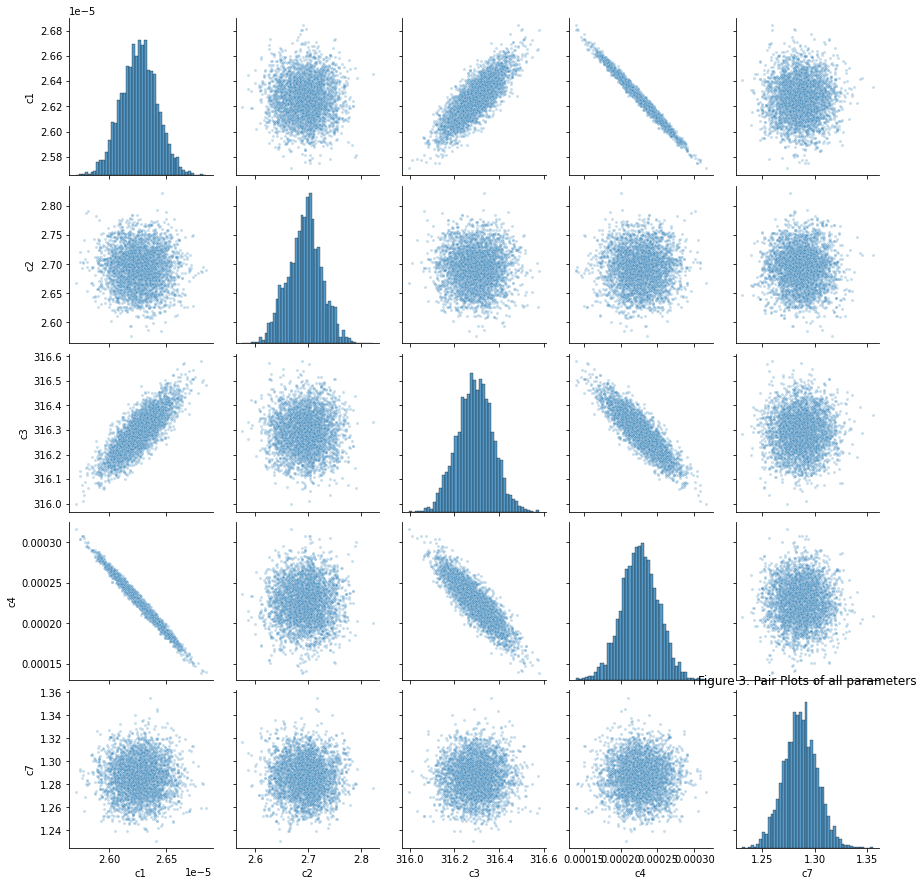

In [ ]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

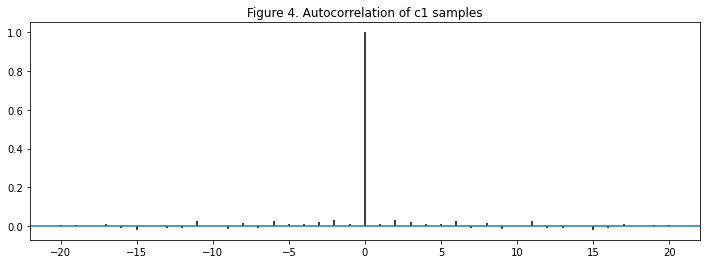

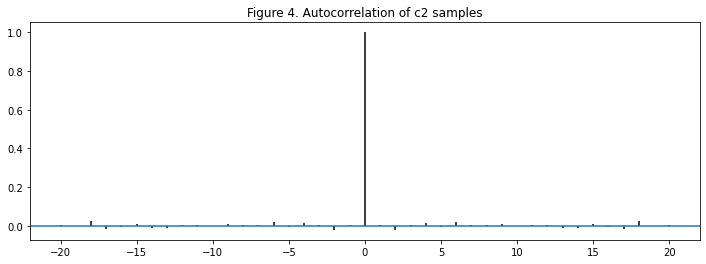

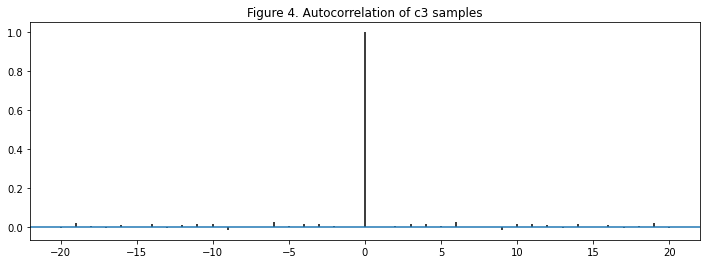

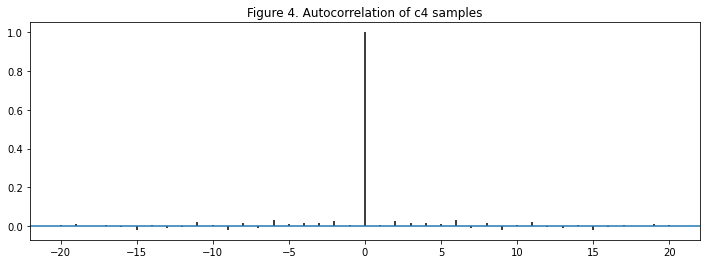

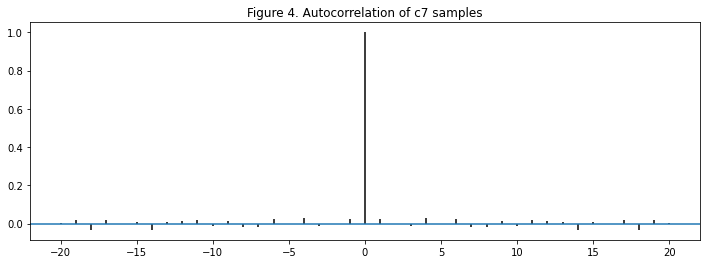

In [ ]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()